<a href="https://colab.research.google.com/github/moo-337/moo/blob/master/docs/get_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
import ipywidgets as widgets # Loads the Widget framework.
from IPython.core.magics.namespace import NamespaceMagics # Used to query namespace.

# For this example, hide these names, just to avoid polluting the namespace further
get_ipython().user_ns_hidden['widgets'] = widgets
get_ipython().user_ns_hidden['NamespaceMagics'] = NamespaceMagics

class VariableInspectorWindow(object):
    instance = None
    
    def __init__(self, ipython):
        """Public constructor."""
        if VariableInspectorWindow.instance is not None:
            raise Exception("""Only one instance of the Variable Inspector can exist at a 
                time.  Call close() on the active instance before creating a new instance.
                If you have lost the handle to the active instance, you can re-obtain it
                via `VariableInspectorWindow.instance`.""")
        
        VariableInspectorWindow.instance = self
        self.closed = False
        self.namespace = NamespaceMagics()
        self.namespace.shell = ipython.kernel.shell
        
        self._box = widgets.Box()
        self._box.layout.overflow_y = 'scroll'
        self._table = widgets.HTML(value = 'Not hooked')
        self._box.children = [self._table]
        
        self._ipython = ipython
        self._ipython.events.register('post_run_cell', self._fill)
        
    def close(self):
        """Close and remove hooks."""
        if not self.closed:
            self._ipython.events.unregister('post_run_cell', self._fill)
            self._box.close()
            self.closed = True
            VariableInspectorWindow.instance = None

    def _fill(self, _result):
        """Fill self with variable information."""
        values = self.namespace.who_ls()
        self._table.value = '<div class="rendered_html jp-RenderedHTMLCommon"><table><thead><tr><th>Name</th><th>Type</th><th>Value</th></tr></thead><tr><td>' + \
            '</td></tr><tr><td>'.join(['{0}</td><td>{1}</td><td>{2}'.format(v, type(eval(v)).__name__, str(eval(v))) for v in values]) + \
            '</td></tr></table></div>'

    def _ipython_display_(self):
        """Called when display() or pyout is used to display the Variable 
        Inspector."""
        self._box._ipython_display_()

inspector = VariableInspectorWindow(get_ipython())
inspector

Box(children=(HTML(value='Not hooked'),), layout=Layout(overflow_y='scroll'))

In [2]:
import numpy as np
import tensorflow as tf
print("TF version =", tf.__version__)

TF version = 2.9.2


In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot

from tensorflow.keras import initializers
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import scipy.stats as stats

In [4]:
global strike, sigma, coupon

N = 100
S0 = 1
T = 1
strike = 0.8
sigma = 0.4
coupon = 0.12

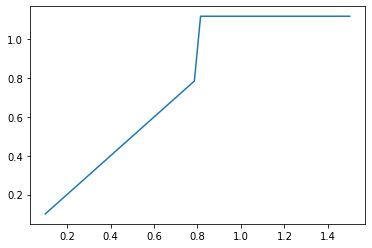

In [5]:


def payoff_f(x):
    # if len(x[0]) > 1:
    #     x = K.min(x, axis=1)
    b = K.greater_equal(x, strike)
    b = K.cast(b, "float32")
    return (1+coupon)*b + x*(1-b)

x = np.linspace(0.1, 1.5, 50).reshape((-1,1))

plt.plot(x, payoff_f(x))

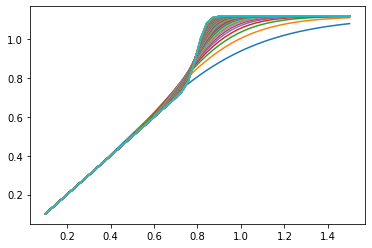

In [6]:
def cash_or_nothing_C(S, K, T, sigma):
    return stats.norm.cdf((np.log(S/K)+(-0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1)

def asset_or_nothing_P(S, K, T, sigma):
    return S*stats.norm.cdf(-(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1)

def conC_delta(S, K, T, sigma):
    return stats.norm.cdf((np.log(S/K)+(-0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1) / (sigma*np.sqrt(T)*S)

def aonP_delta(S, K, T, sigma):
    return stats.norm.cdf(-(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1) - stats.norm.pdf(-(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1) / (sigma*np.sqrt(T))

def BS_closedform(S, T):
    return (1+coupon)*cash_or_nothing_C(S, strike, T, sigma) + asset_or_nothing_P(S, strike, T, sigma)

def BS_delta(S, T):
    return (1+coupon)*conC_delta(S, strike, T, sigma) + aonP_delta(S, strike, T, sigma)

for i in range(N):
    plt.plot(x, BS_closedform(x, T/(i+1)))

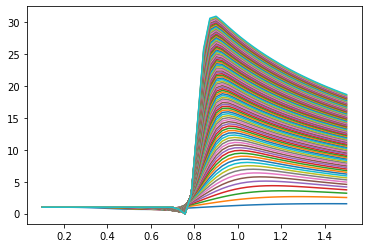

In [7]:
for i in range(N):
    plt.plot(x, BS_delta(x, T/(i+1)))

In [8]:
u = 1
m = 1
d = 3
n = 32

layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]


price = Input(shape=(u,))
hedge = Input(shape=(u,))
hedgeeval = Input(shape=(u,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper = []

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,0.1),
                          bias_initializer=initializers.RandomNormal(0,0.1))(premium)

for j in range(N):
    strategy = price
    strategyeval = hedgeeval
    for k in range(d):
        strategy = layers[k+(j)*d](strategy)
        strategyeval = layers[k+(j)*d](strategyeval)
    
    incr = Input(shape=(u,))
    logprice = Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])

    pricenew = Lambda(lambda x : K.exp(x))(logprice)
    priceincr = Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    hedge = Add()([hedge, hedgenew])
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price = pricenew

In [9]:
payoff = Lambda(payoff_f)(price)
outputs = Subtract()([payoff, hedge])
outputs = Subtract()([outputs, premium])
outputs = [outputs] + outputhelper + [premium]
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)

In [10]:
gamma = 1.0
grid = [(i/N)**gamma*T for i in range(N+1)]

Ktrain = 10**5
initialprice = S0
priceBS = (1+coupon)*cash_or_nothing_C(initialprice, strike, T, sigma) + asset_or_nothing_P(initialprice, strike, T, sigma)


xtrain = ([initialprice*np.ones((Ktrain, u))] + 
          [np.zeros((Ktrain, m))] +
          [np.ones((Ktrain, m))] +
          [priceBS*np.ones((Ktrain, m))] + 
          [np.random.normal(-(sigma)**2/2*(grid[i+1]-grid[i]), sigma*np.sqrt(grid[i+1]-grid[i]), (Ktrain, u)) for i in range(N)])

ytrain = np.zeros((Ktrain, 1+N))

In [11]:
def loss_mse(y_true, y_pred):
    return K.mean(K.square(y_pred[:, 0]-y_true[:,0]))

model_hedge_strat.compile(optimizer='adam', loss=loss_mse)

for i in range(50):
    model_hedge_strat.fit(x=xtrain, y=ytrain, epochs=1, verbose=True, batch_size=1000)

100/100 [==============================] - 7s 70ms/step - loss: 0.0020


In [12]:
logincrements = xtrain[4:4+N]
hedge = np.zeros(Ktrain)
price = S0*np.ones((Ktrain, N))

for k in range(N-1):
    helper = logincrements[k][:,]
    helper = helper.transpose()
    price[:, k+1] = price[:, k]*np.exp(helper)
    hedge = hedge + ((1+coupon)*conC_delta(price[:,k], strike, T-grid[k+1], sigma) + aonP_delta(price[:,k], strike, T-grid[k+1], sigma)) * (price[:, k+1] - price[:, k])

hedge = hedge - payoff_f(price[:, N-1]) + priceBS

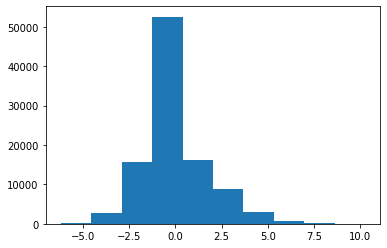

1.7265775 0.0015048234


In [13]:
plt.hist(hedge)
plt.show()
print(np.std(hedge), np.mean(hedge))

(array([4.3000e+01, 5.6700e+02, 2.4540e+03, 5.4730e+03, 8.5790e+03,
        1.0512e+04, 8.1150e+03, 0.0000e+00, 0.0000e+00, 6.4257e+04]),
 array([0.14775237, 0.24497713, 0.3422019 , 0.43942666, 0.53665143,
        0.6338762 , 0.731101  , 0.8283257 , 0.92555046, 1.0227753 ,
        1.12      ], dtype=float32),
 <a list of 10 Patch objects>)

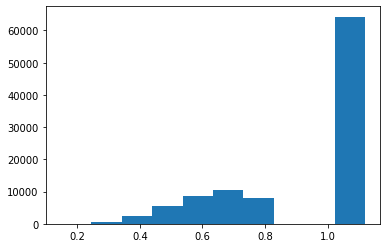

In [14]:
plt.hist(payoff_f(price[:, N-1]))

In [15]:
Ktest=50

testpath=[]

for i in range(N):
    testpath.append(np.random.normal(-(sigma)**2/2*(grid[i+1]-grid[i]), sigma*np.sqrt(grid[i+1]-grid[i]), (Ktest, u)))

logincrements = testpath
hedge = np.zeros((Ktest, N+1))
price = S0*np.ones((Ktest, N+1))
delta = np.zeros((Ktest, N+1))
delta[:, 0] += ((1+coupon)*conC_delta(price[:,0], strike, T-grid[0], sigma) + aonP_delta(price[:,0], strike, T-grid[0], sigma))
for k in range(N):
    helper = logincrements[k].reshape((-1,))
    price[:, k+1] = price[:, k]*np.exp(helper)
    delta[:, k+1] += ((1+coupon)*conC_delta(price[:,k], strike, T-grid[k+1], sigma) + aonP_delta(price[:,k], strike, T-grid[k+1], sigma))
    hedge[:, k+1] = hedge[:, k] + delta[:, k+1] * (price[:, k+1] - price[:, k])

hedge[:, -1] = hedge[:, -2] - payoff_f(price[:, -1]) + priceBS

<ipython-input-6-0d73b11d0ec8>:8: RuntimeWarning: divide by zero encountered in true_divide
  return stats.norm.cdf((np.log(S/K)+(-0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1) / (sigma*np.sqrt(T)*S)
<ipython-input-6-0d73b11d0ec8>:8: RuntimeWarning: invalid value encountered in true_divide
  return stats.norm.cdf((np.log(S/K)+(-0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1) / (sigma*np.sqrt(T)*S)
<ipython-input-6-0d73b11d0ec8>:11: RuntimeWarning: divide by zero encountered in true_divide
  return stats.norm.cdf(-(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1) - stats.norm.pdf(-(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1) / (sigma*np.sqrt(T))
<ipython-input-6-0d73b11d0ec8>:11: RuntimeWarning: invalid value encountered in true_divide
  return stats.norm.cdf(-(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1) - stats.norm.pdf(-(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1) / (sigma*np.sqrt(T))


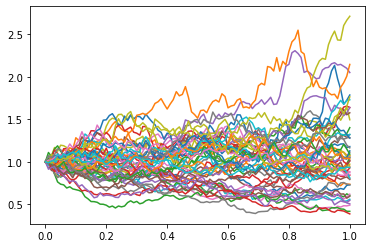

In [16]:
for i in range(Ktest):
    plt.plot(grid[:], price[i])

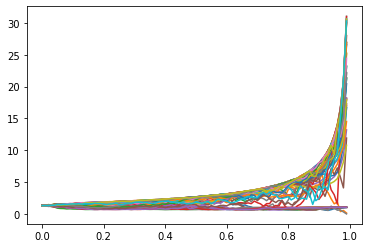

In [17]:
for i in range(Ktest):
    plt.plot(grid[:], delta[i])


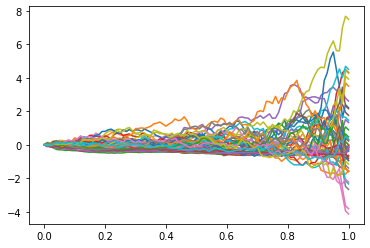

In [18]:
for i in range(Ktest):
    plt.plot(grid, hedge[i])

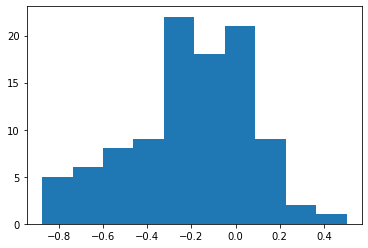

0.2789737869436908 -0.2131446759981621


In [19]:
plt.hist(hedge[-1])
plt.show()
print(np.std(hedge[-1]), np.mean(hedge[-1]))

2/2 [==============================] - 0s 38ms/step


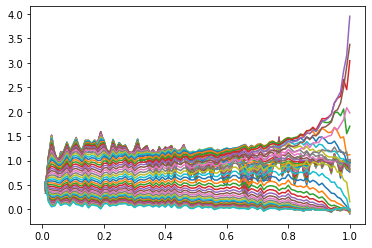

In [23]:
xtest = ([initialprice*np.ones((Ktest, u))] + 
         [np.zeros((Ktest, m))] + 
         [np.linspace(0.1, 1.5, Ktest)] +
         [priceBS*np.ones((Ktest, m))] + 
         [testpath[i] for i in range(N)])

y = model_hedge_strat.predict(xtest)
    
model_hedge = y[:, 0]
model_premium = y[:, -1]

for k in range(Ktest):
    plt.plot(grid[1:], y[k][1:-1])

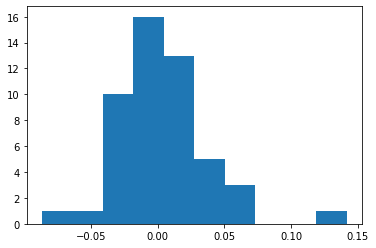

0.034560032 0.005027032


In [24]:
plt.hist(model_hedge)
plt.show()
print(np.std(model_hedge), np.mean(model_hedge))

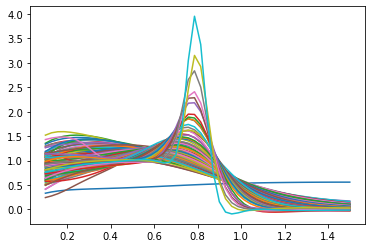

In [31]:
s = np.linspace(0.1, 1.5, Ktest)

for i in range(N):
    plt.plot(s, y[:, i+1])

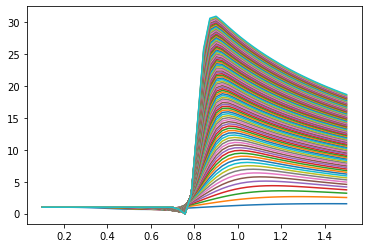

In [32]:

for i in range(N):
    BSdelta = BS_delta(s, T/(i+1))
    plt.plot(s, BSdelta)

In [26]:
hedge = np.zeros((Ktest, N+1))
price = S0*np.ones((Ktest, N))

for k in range(N-1):
    helper = logincrements[k].reshape((-1,))
    price[:, k+1] = price[:, k]*np.exp(helper)
    hedge[:, k+1] = hedge[:, k] + y[0][k+1] * (price[:, k+1] - price[:, k])

hedge[:, -1] = hedge[:, -2] - payoff_f(price[:, N-1]) + priceBS

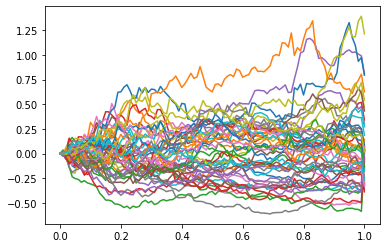

In [27]:
for i in range(Ktest):
    plt.plot(grid, hedge[i])

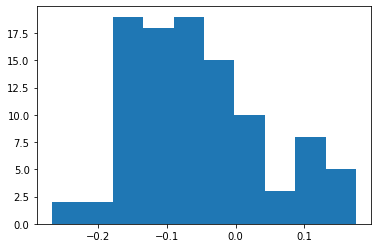

0.0945459624238328 -0.05376503756493406


In [28]:
plt.hist(hedge[-1])
plt.show()
print(np.std(hedge[-1]), np.mean(hedge[-1]))